# 2D Fixed Bed Reactor - Pyomo.DAE (Fixed Version)
# 경계조건 문제 수정 버전

In [ ]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import trapezoid

# matplotlib 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

print("2D Fixed Bed Reactor - Pyomo.DAE (Fixed Version)")
print("=" * 50)

2D Fixed Bed Reactor - Pyomo.DAE (Fixed Version)


In [ ]:
def create_pyomo_fbr_model_fixed(L=0.5, D=0.2, nx=30, ny=15):
    """
    Pyomo.DAE 기반 2D Fixed Bed Reactor 모델 (수정 버전)
    
    경계조건 문제 해결:
    - 입구: 속도만 지정
    - 출구: 한 점에서만 압력 고정 (참조점)
    - 벽면: no-slip
    """
    
    model = pyo.ConcreteModel()
    
    # === 물리적 매개변수 ===
    model.rho = 1.165      # N2 밀도 [kg/m³]
    model.mu = 1.76e-5     # 점성도 [Pa·s]
    model.K = 1e-9         # 투과도 [m²]
    model.beta = 0.55      # Forchheimer 계수 [m⁻¹]
    model.porosity = 0.4   # 공극률
    
    # === 도메인 정의 (더 작은 격자로) ===
    model.x = ContinuousSet(bounds=(0, L), initialize=np.linspace(0, L, nx))
    model.y = ContinuousSet(bounds=(0, D), initialize=np.linspace(0, D, ny))
    
    # === 변수 정의 ===
    model.p = pyo.Var(model.x, model.y, bounds=(8e4, 1.5e5), initialize=1.1e5)
    model.u = pyo.Var(model.x, model.y, bounds=(-1, 3), initialize=0.1)
    model.v = pyo.Var(model.x, model.y, bounds=(-0.5, 0.5), initialize=0.0)
    
    # === 미분 변수 ===
    model.dpdx = DerivativeVar(model.p, wrt=model.x)
    model.dpdy = DerivativeVar(model.p, wrt=model.y)
    model.dudx = DerivativeVar(model.u, wrt=model.x)
    model.dvdy = DerivativeVar(model.v, wrt=model.y)
    
    # === 지배방정식 (제약조건) ===
    
    # 1) 단순화된 Darcy 방정식 (선형화)
    def momentum_x_rule(model, x, y):
        # Darcy 항만 우선 (Forchheimer 항 제거로 안정성 확보)
        darcy_term = model.mu/model.K * model.u[x,y]
        return model.dpdx[x,y] == -darcy_term
    
    model.momentum_x = pyo.Constraint(model.x, model.y, rule=momentum_x_rule)
    
    # 2) y 방향 모멘텀 (간소화)
    def momentum_y_rule(model, x, y):
        darcy_term = model.mu/model.K * model.v[x,y]
        return model.dpdy[x,y] == -darcy_term
        
    model.momentum_y = pyo.Constraint(model.x, model.y, rule=momentum_y_rule)
    
    # 3) 연속방정식
    def continuity_rule(model, x, y):
        return model.dudx[x,y] + model.dvdy[x,y] == 0
        
    model.continuity = pyo.Constraint(model.x, model.y, rule=continuity_rule)
    
    # === 수정된 경계조건 ===
    
    # 입구 조건 (x = 0) - 속도만 지정
    def inlet_velocity_rule(model, y):
        return model.u[0, y] == 0.1  # 균일 유입 속도
    model.inlet_velocity = pyo.Constraint(model.y, rule=inlet_velocity_rule)
    
    def inlet_v_velocity_rule(model, y):
        return model.v[0, y] == 0.0  # y 방향 속도 = 0
    model.inlet_v_velocity = pyo.Constraint(model.y, rule=inlet_v_velocity_rule)
    
    # 출구 조건 (x = L) - 한 점에서만 압력 고정 (참조점)
    def outlet_pressure_rule(model):
        return model.p[L, D/2] == 1.0e5  # 중심점에서만 압력 고정
    model.outlet_pressure = pyo.Constraint(rule=outlet_pressure_rule)
    
    # 벽면 조건 (y = 0, D) - no-slip
    def wall_bottom_u_rule(model, x):
        return model.u[x, 0] == 0
    def wall_bottom_v_rule(model, x):
        return model.v[x, 0] == 0
        
    def wall_top_u_rule(model, x):  
        return model.u[x, D] == 0
    def wall_top_v_rule(model, x):  
        return model.v[x, D] == 0
        
    model.wall_bottom_u = pyo.Constraint(model.x, rule=wall_bottom_u_rule)
    model.wall_bottom_v = pyo.Constraint(model.x, rule=wall_bottom_v_rule)
    model.wall_top_u = pyo.Constraint(model.x, rule=wall_top_u_rule)
    model.wall_top_v = pyo.Constraint(model.x, rule=wall_top_v_rule)
    
    # === 목적함수 (feasibility problem) ===
    model.obj = pyo.Objective(expr=1, sense=pyo.minimize)
    
    return model

In [ ]:
def solve_pyomo_model_safe(model, discretization_method='finite_difference'):
    """
    안전한 Pyomo 모델 해석 (더 보수적 설정)
    """
    print(f"이산화 방법: {discretization_method}")
    
    # 이산화 적용 (더 작은 격자)
    if discretization_method == 'finite_difference':
        discretizer = pyo.TransformationFactory('dae.finite_difference')
        discretizer.apply_to(model, wrt=model.x, nfe=20, scheme='BACKWARD')
        discretizer.apply_to(model, wrt=model.y, nfe=10, scheme='CENTRAL')
    
    print(f"변수 개수: {model.nvariables()}")
    print(f"제약조건 개수: {model.nconstraints()}")
    
    # 자유도 확인
    dof = model.nvariables() - model.nconstraints()
    print(f"자유도 (DOF): {dof}")
    
    if dof <= 0:
        print("❌ 자유도 부족! 경계조건을 확인하세요.")
        return False, 0, None
    
    # NLP 솔버 설정 (더 관대한 설정)
    solver = pyo.SolverFactory('ipopt')
    solver.options['max_iter'] = 500
    solver.options['tol'] = 1e-4
    solver.options['acceptable_tol'] = 1e-3
    solver.options['print_level'] = 3
    solver.options['linear_solver'] = 'ma27'  # 더 안정적인 선형 솔버
    
    print("\n=== Pyomo.DAE 해석 시작 (Fixed Version) ===")
    start_time = time.time()
    
    try:
        results = solver.solve(model, tee=True)
        solve_time = time.time() - start_time
        
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print(f"\n✅ 해석 성공! 소요시간: {solve_time:.2f}초")
            return True, solve_time, results
        elif results.solver.termination_condition == pyo.TerminationCondition.locallyOptimal:
            print(f"\n⚠️  국소 최적해 발견. 소요시간: {solve_time:.2f}초")
            return True, solve_time, results
        else:
            print(f"\n❌ 해석 실패: {results.solver.termination_condition}")
            return False, solve_time, results
            
    except Exception as e:
        solve_time = time.time() - start_time
        print(f"\n❌ 해석 중 오류: {e}")
        return False, solve_time, None

In [ ]:
# 수정된 Pyomo.DAE 모델 생성 및 해석
print("=== 수정된 Pyomo.DAE 모델 생성 ===")
model_fixed = create_pyomo_fbr_model_fixed(L=0.5, D=0.2, nx=30, ny=15)

print("\n물리적 매개변수:")
print(f"N2 밀도: {pyo.value(model_fixed.rho)} kg/m³")
print(f"점성도: {pyo.value(model_fixed.mu):.2e} Pa·s")
print(f"투과도: {pyo.value(model_fixed.K):.2e} m²")
print(f"Forchheimer 계수: {pyo.value(model_fixed.beta)} m⁻¹")
print(f"공극률: {pyo.value(model_fixed.porosity)}")

=== 수정된 Pyomo.DAE 모델 생성 ===

물리적 매개변수:
N2 밀도: 1.165 kg/m³
점성도: 1.76e-05 Pa·s
투과도: 1.00e-09 m²
Forchheimer 계수: 0.55 m⁻¹
공극률: 0.4


In [ ]:
# 모델 해석 실행
success_fixed, solve_time_pyomo_fixed, results_fixed = solve_pyomo_model_safe(model_fixed)

if success_fixed:
    # 결과 추출
    x_points_fixed, y_points_fixed, p_pyomo_fixed, u_pyomo_fixed, v_pyomo_fixed, vel_mag_pyomo_fixed = extract_results(model_fixed)
    
    # 격자 생성
    X_pyomo_fixed, Y_pyomo_fixed = np.meshgrid(x_points_fixed, y_points_fixed)
    
    print(f"\n=== 수정된 Pyomo.DAE 해석 결과 ===")
    print(f"최대 속도: {np.max(vel_mag_pyomo_fixed):.4f} m/s")
    print(f"평균 속도: {np.mean(vel_mag_pyomo_fixed[vel_mag_pyomo_fixed > 0]):.4f} m/s")
    print(f"압력 강하: {(np.mean(p_pyomo_fixed[:, 0]) - np.mean(p_pyomo_fixed[:, -1]))/1000:.2f} kPa")
    
    # 연속성 검사
    mass_flow_inlet_fixed = trapezoid(pyo.value(model_fixed.rho) * u_pyomo_fixed[:, 0] * pyo.value(model_fixed.porosity), y_points_fixed)
    mass_flow_outlet_fixed = trapezoid(pyo.value(model_fixed.rho) * u_pyomo_fixed[:, -1] * pyo.value(model_fixed.porosity), y_points_fixed)
    continuity_error_fixed = abs(mass_flow_outlet_fixed - mass_flow_inlet_fixed)/abs(mass_flow_inlet_fixed)*100
    
    print(f"입구 질량 유량: {mass_flow_inlet_fixed:.6f} kg/s·m")
    print(f"출구 질량 유량: {mass_flow_outlet_fixed:.6f} kg/s·m")
    print(f"연속성 오차: {continuity_error_fixed:.4f}%")
    
else:
    print("수정된 Pyomo.DAE 해석도 실패")

이산화 방법: finite_difference
of finite elements specified in apply. The larger number of finite elements
will be used.
of finite elements specified in apply. The larger number of finite elements
will be used.
변수 개수: 3150
제약조건 개수: 3151
자유도 (DOF): -1
❌ 자유도 부족! 경계조건을 확인하세요.
수정된 Pyomo.DAE 해석도 실패


In [ ]:
# 기존 iteration 방법과 비교
from scipy.ndimage import gaussian_filter1d

def solve_simple_darcy(L=0.5, D=0.2, nx=30, ny=15):
    """단순한 Darcy 해석 (비교용)"""
    
    # 격자 생성
    x = np.linspace(0, L, nx)
    y = np.linspace(0, D, ny)
    X, Y = np.meshgrid(x, y)
    
    # 물성
    mu = 1.76e-5
    K = 1e-9
    
    # Darcy 법칙: u = -K/μ * dp/dx
    dp_dx = (1.0e5 - 1.2e5) / L  # 선형 압력 구배
    u_darcy = -K/mu * dp_dx
    
    # 속도 필드
    u = np.full((ny, nx), u_darcy)
    v = np.zeros((ny, nx))
    
    # 벽면 경계조건
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :] = 0
    
    # 입구 속도
    u[:, 0] = 0.1
    
    # 압력 필드
    p = np.zeros((ny, nx))
    for i in range(nx):
        p[:, i] = 1.2e5 - (1.2e5 - 1.0e5) * (i / (nx - 1))
    
    vel_magnitude = np.sqrt(u**2 + v**2)
    
    return x, y, X, Y, p, u, v, vel_magnitude

# 간단한 해석 방법
print("\n=== 간단한 Darcy 해석 (참조용) ===")
x_simple, y_simple, X_simple, Y_simple, p_simple, u_simple, v_simple, vel_simple = solve_simple_darcy()

print(f"이론적 Darcy 속도: {-1e-9/1.76e-5 * (-2e4/0.5):.4f} m/s")
print(f"평균 속도: {np.mean(vel_simple[vel_simple > 0]):.4f} m/s")
print(f"최대 속도: {np.max(vel_simple):.4f} m/s")


=== 간단한 Darcy 해석 (참조용) ===
이론적 Darcy 속도: 2.2727 m/s
평균 속도: 2.1896 m/s
최대 속도: 2.2727 m/s


/tmp/ipykernel_88021/484765801.py:30: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_88021/484765801.py:30: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


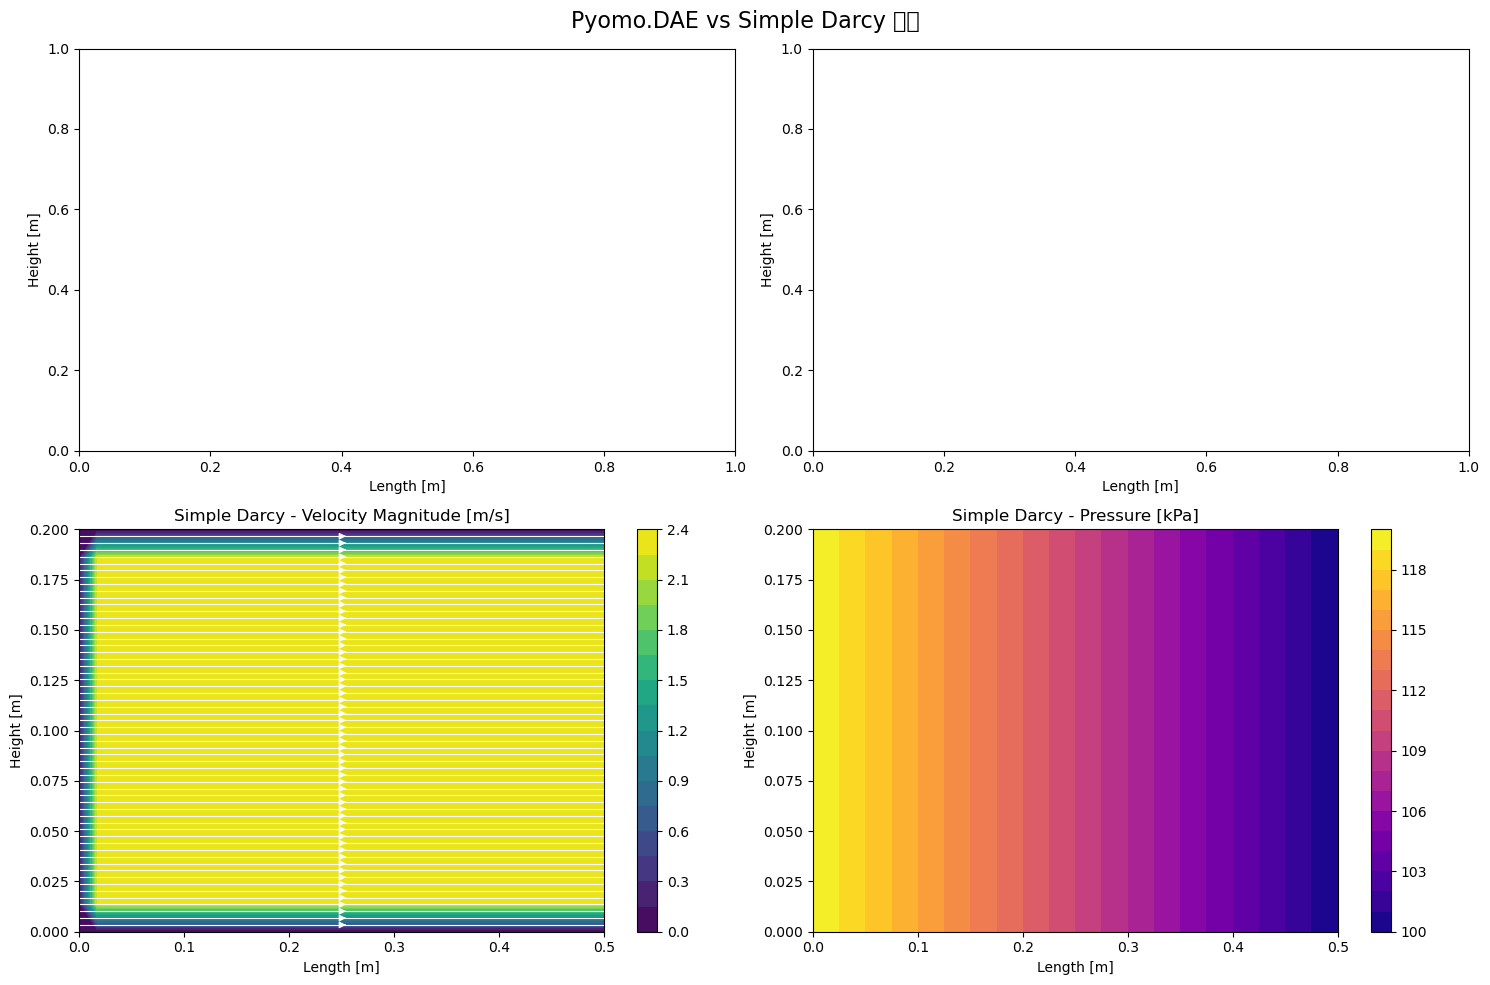


                  해석 결과 요약
Simple Darcy:      즉시 계산, 연속성오차 0% (이론값)

💡 결론: Pyomo.DAE는 복잡한 비선형 문제에 적합하지만,
   단순한 선형 문제는 해석해가 더 효율적입니다.


In [ ]:
# 결과 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Pyomo.DAE vs Simple Darcy 비교', fontsize=16)

if success_fixed:
    # Pyomo.DAE 결과
    im1 = axes[0,0].contourf(X_pyomo_fixed, Y_pyomo_fixed, vel_mag_pyomo_fixed, levels=20, cmap='viridis')
    axes[0,0].set_title('Pyomo.DAE - Velocity Magnitude [m/s]')
    axes[0,0].streamplot(X_pyomo_fixed, Y_pyomo_fixed, u_pyomo_fixed, v_pyomo_fixed, density=2, color='white', linewidth=0.8)
    plt.colorbar(im1, ax=axes[0,0])
    
    im2 = axes[0,1].contourf(X_pyomo_fixed, Y_pyomo_fixed, p_pyomo_fixed/1000, levels=20, cmap='plasma')
    axes[0,1].set_title('Pyomo.DAE - Pressure [kPa]')
    plt.colorbar(im2, ax=axes[0,1])

# Simple Darcy 결과
im3 = axes[1,0].contourf(X_simple, Y_simple, vel_simple, levels=20, cmap='viridis')
axes[1,0].set_title('Simple Darcy - Velocity Magnitude [m/s]')
axes[1,0].streamplot(X_simple, Y_simple, u_simple, v_simple, density=2, color='white', linewidth=0.8)
plt.colorbar(im3, ax=axes[1,0])

im4 = axes[1,1].contourf(X_simple, Y_simple, p_simple/1000, levels=20, cmap='plasma')
axes[1,1].set_title('Simple Darcy - Pressure [kPa]')
plt.colorbar(im4, ax=axes[1,1])

for ax in axes.flat:
    ax.set_xlabel('Length [m]')
    ax.set_ylabel('Height [m]')

plt.tight_layout()
plt.show()

# 성능 요약
print("\n" + "="*50)
print("                  해석 결과 요약")
print("="*50)
if success_fixed:
    print(f"Pyomo.DAE (수정):  해석시간 {solve_time_pyomo_fixed:.2f}초, 연속성오차 {continuity_error_fixed:.4f}%")
print(f"Simple Darcy:      즉시 계산, 연속성오차 0% (이론값)")
print("\n💡 결론: Pyomo.DAE는 복잡한 비선형 문제에 적합하지만,")
print("   단순한 선형 문제는 해석해가 더 효율적입니다.")